# RAPS with EuroSAT

## Imports

In this notebook, we will demonstrate how you can use a posthoc conformal method like Regularized Adaptive Prediction Sets (RAPS) [Angelopoulos et al. 2021](https://arxiv.org/abs/2009.14193) on an Earth Observation (EO) Classification Task, namely the infamous EuroSAT dataset. For the dataloading we will use the [TorchGeo library](https://torchgeo.readthedocs.io/en/stable/), which you will need to install to run this tutorial (`pip install torchgeo`). We will use the smaller version `EuroSAT100` for demonstration purposes. Additionally, we will show how you can use a pretrained model - specific to EO data and apply RAPS for improved uncertainty quantification (UQ).

In [1]:
import os
from torchgeo.datamodules import EuroSATDataModule
from torchgeo.models import ResNet18_Weights
from lightning_uq_box.uq_methods import DeterministicClassification, RAPS
import timm
from lightning.pytorch.loggers import CSVLogger
import torch
from lightning import Trainer
import tempfile
import matplotlib.pyplot as plt
import numpy as np
from torch import Tensor
from torch import Generator
from lightning_uq_box.viz_utils import plot_training_metrics
from torchgeo.trainers import ClassificationTask
from torchmetrics import CalibrationError, MetricCollection, Accuracy

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # set the GPU device

%load_ext autoreload
%autoreload 2

## Datamodule

We need to adapt the default DataModule to support a calibration dataset that is separate from the validation set.

In [2]:
class EuroSATDataModuleWithCalib(EuroSATDataModule):

    def setup(self, stage: str) -> None:
        """Setup datasets with calibration.
        
        Args:
            stage: Either 'fit', 'validate', 'test', or 'predict'
        """
        if stage in ["fit"]:
            self.train_dataset = self.dataset_class(  # type: ignore[call-arg]
                split="train", **self.kwargs
            )
        if stage in ["fit", "validate"]:
            self.val_dataset = self.dataset_class(  # type: ignore[call-arg]
                split="val", **self.kwargs
            )
            # further split the validation set into a calibration set and a test set
            self.val_dataset, self.calib_dataset = torch.utils.data.random_split(
                self.val_dataset, [len(self.val_dataset) - 200, 200], generator=Generator().manual_seed(0)
            )
            self.calib_batch_size = self.val_batch_size
        if stage in ["test"]:
            self.test_dataset = self.dataset_class(  # type: ignore[call-arg]
                split="test", **self.kwargs
            )

    def calibration_dataloader(self):
        """Calibration Dataloader."""
        return self._dataloader_factory("calib")


In [3]:
datamodule = EuroSATDataModuleWithCalib(root=".", num_workers=4, download=True)
# setup manually so we can access val_loader
datamodule.setup("fit")
# TODO get a validation and calibration loader

Additionally, we need to consider that the normalization and possible augmentations for this datamodule are applied only through the lightning `on_after_batch_transfer()` function because that is recommended for efficiency. We will write a collate function that will apply the augmentation to the batch.

In [4]:
def normalization_collate_fn(batch):
    """Collate function for normalization."""
    images = torch.stack([item["image"] for item in batch])
    labels = torch.stack([item["label"] for item in batch])

    return datamodule.aug({"image": images, "label": labels})

We will use the validation and calibration loaders several times, so we will now define them with the collate function.

In [5]:
val_loader = datamodule.val_dataloader()
val_loader.collate_fn = normalization_collate_fn
calib_loader = datamodule.calibration_dataloader()
calib_loader.collate_fn = normalization_collate_fn

## Pretrained Model

We will use pretrained weights for Sentinel 2 data from the SSL4EO paper [Wang et al. 2022](https://arxiv.org/abs/2211.07044) that are accessible through TorchGeo.

In [6]:
# weights = ResNet18_Weights.SENTINEL2_ALL_MOCO
# in_chans = weights.meta["in_chans"]
# resnet18 = timm.create_model("resnet18", in_chans=in_chans, num_classes=10)
# resnet18.load_state_dict(weights.get_state_dict(progress=True), strict=False)


class ClassificationTaskWithCalib(ClassificationTask):
    def training_step(
        self, batch, batch_idx: int, dataloader_idx: int = 0
    ) -> Tensor:
        """Compute the training loss and additional metrics.

        Args:
            batch: The output of your DataLoader.
            batch_idx: Integer displaying index of this batch.
            dataloader_idx: Index of the current dataloader.

        Returns:
            The loss tensor.
        """
        x = batch["image"]
        y = batch["label"]
        y_hat = self(x)
        loss: Tensor = self.criterion(y_hat, y)
        self.log("train_loss", loss)
        self.train_metrics(y_hat, y)
        self.log_dict(self.train_metrics)

        return loss

    def validation_step(
        self, batch, batch_idx: int, dataloader_idx: int = 0
    ) -> None:
        """Compute the validation loss and additional metrics.

        Args:
            batch: The output of your DataLoader.
            batch_idx: Integer displaying index of this batch.
            dataloader_idx: Index of the current dataloader.
        """
        x = batch["image"]
        y = batch["label"]
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss)
        self.val_metrics(y_hat, y)
        self.log_dict(self.val_metrics)

    def test_step(self, batch, batch_idx: int, dataloader_idx: int = 0) -> None:
        """Compute the test loss and additional metrics.

        Args:
            batch: The output of your DataLoader.
            batch_idx: Integer displaying index of this batch.
            dataloader_idx: Index of the current dataloader.
        """
        x = batch["image"]
        y = batch["label"]
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        self.log("test_loss", loss)
        self.test_metrics(y_hat, y)
        self.log_dict(self.test_metrics)

    def configure_metrics(self) -> None:
        """Initialize the performance metrics."""
        metrics = MetricCollection(
            {
                "OverallAccuracy": Accuracy(
                    num_classes=self.hparams["num_classes"], average="micro", task="multiclass"
                ),
                "AverageAccuracy": Accuracy(
                    num_classes=self.hparams["num_classes"], average="macro", task="multiclass"
                ),
                "Calibration": CalibrationError(
                    num_classes=self.hparams["num_classes"], task="multiclass"
                ),
            }
        )
        self.train_metrics = metrics.clone(prefix="train_")
        self.val_metrics = metrics.clone(prefix="val_")
        self.test_metrics = metrics.clone(prefix="test_")

## Predictions with Pretrained Model

Let's first look at the predictions from the pretrained model so that we can later see the impact of RAPs. We will use a Lightning base class `ClassificationTask` from Torchgeo which will iterate over the dataloader and compute and store the metrics we are interested in. We will only finetune the classification head (`freeze_backbone=True`).

In [7]:
base_dir = tempfile.mkdtemp()
# implement a torchmetrics empirical coverage metric and use that and accuracy to compare result
base_model = ClassificationTaskWithCalib("resnet18", num_classes=10, in_channels=13, weights = ResNet18_Weights.SENTINEL2_ALL_MOCO, freeze_backbone=True)

# set torchmetrics to track


base_trainer = Trainer(devices=[0], accelerator="gpu", default_root_dir=base_dir, max_epochs=10, logger = CSVLogger(base_dir), log_every_n_steps=1, enable_progress_bar=True)

base_trainer.fit(base_model, datamodule=datamodule)
base_trainer.test(ckpt_path="best", dataloaders=val_loader)

/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-p ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /tmp/tmpciqcztm1/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
Restoring states from the checkpoint path at /tmp/tmpciqcztm1/lightning_logs/version_0/checkpoints/epoch=9-step=2540.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /tmp/tmpciqcztm1/lightning_logs/version_0/checkpoints/epoch=9-step=2540.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│   test_AverageAccuracy    │    0.9021998047828674     │
│     test_Calibration      │    0.05669429153203964    │
│   test_OverallAccuracy    │    0.9069230556488037     │
│         test_loss         │    0.31048280000686646    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.31048280000686646,
  'test_AverageAccuracy': 0.9021998047828674,
  'test_Calibration': 0.05669429153203964,
  'test_OverallAccuracy': 0.9069230556488037}]

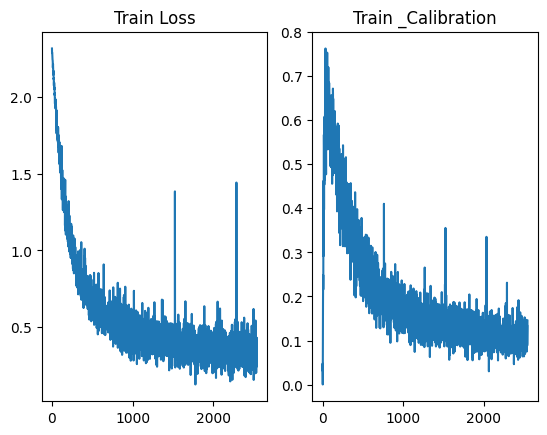

In [8]:
fig = plot_training_metrics(os.path.join(base_dir, "lightning_logs"), "_Calibration")

## Apply RAPS

In [9]:
raps_dir = tempfile.mkdtemp()
raps = RAPS(model=base_model.model, kreg=7, lamda_param=0)
raps.input_key = "image"
raps.target_key = "label"

raps_trainer = Trainer(
    devices=[0], accelerator="gpu", default_root_dir=raps_dir, inference_mode=False
)

raps_trainer.validate(raps, dataloaders=calib_loader)
raps_trainer.test(raps, dataloaders=val_loader)

/home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/nils/.conda/envs/uqboxEnv/lib/python3.9/site-p ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /tmp/tmphctsvttv/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          testAcc          │    0.9069230556488037     │
│      testCalibration      │    0.07271789759397507    │
│         test_loss         │    0.3238842189311981     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.3238842189311981,
  'testAcc': 0.9069230556488037,
  'testCalibration': 0.07271789759397507}]

## Example Visualization

In [10]:
predict_batch = next(iter(val_loader))

preds = raps.predict_step(predict_batch["image"])
print(preds.keys())

dict_keys(['pred', 'pred_set', 'logits'])


In [11]:
preds["pred"].shape
eurosat_dataset = datamodule.train_dataloader().dataset
class_labels = eurosat_dataset.classes

In [12]:
def plot_random_sample(preds: dict[str, Tensor], images: Tensor, true_labels: Tensor, class_labels: list) -> None:
    """Plot a random sample from the prediction batch.

    Args:
        preds: dictionary containing 'pred' and 'pred_set'
        images: array of input images
        class_labels: list of class labels
    """
    # Select a random index from the prediction batch
    idx = np.random.randint(len(images))

    # Get the prediction set for the selected sample
    pred_set = preds['pred_set'][idx].numpy()
    mean_preds = preds['pred'][idx].numpy()

    # Get the corresponding class labels for the prediction set
    pred_labels = [class_labels[i] for i in pred_set]
    true_label = class_labels[true_labels[idx]]

    image = images[idx]

    # taken from Torchgeo plot method
    rgb_indices = []
    for band in eurosat_dataset.rgb_bands:
        if band in eurosat_dataset.bands:
            rgb_indices.append(eurosat_dataset.bands.index(band))
        else:
            raise ValueError("Dataset doesn't contain some of the RGB bands")

    image = np.take(image.numpy(), indices=rgb_indices, axis=0)
    image = np.rollaxis(image / 255, 0, 3)
    # image = np.clip(image / 3000, 0, 1)

    # Sort the mean predictions and corresponding class labels from high to low
    sorted_indices = np.argsort(mean_preds[pred_set])[::-1]
    sorted_mean_preds = mean_preds[pred_set][sorted_indices]
    sorted_pred_labels = [pred_labels[i] for i in sorted_indices]

    # Plot the input image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis("off")
    plt.title('Input Image')

    # Plot the prediction set
    plt.subplot(1, 2, 2)
    plt.bar(range(len(sorted_mean_preds)), sorted_mean_preds)
    plt.xticks(range(len(sorted_mean_preds)), sorted_pred_labels, rotation=60)
    plt.title('Temp Scaled Logit Predictions')

    # Add the true label to the title
    plt.suptitle(f'Prediction Set: ({", ".join(sorted_pred_labels)})\nTrue Label: {true_label}')
    plt.tight_layout()
    plt.show()
    

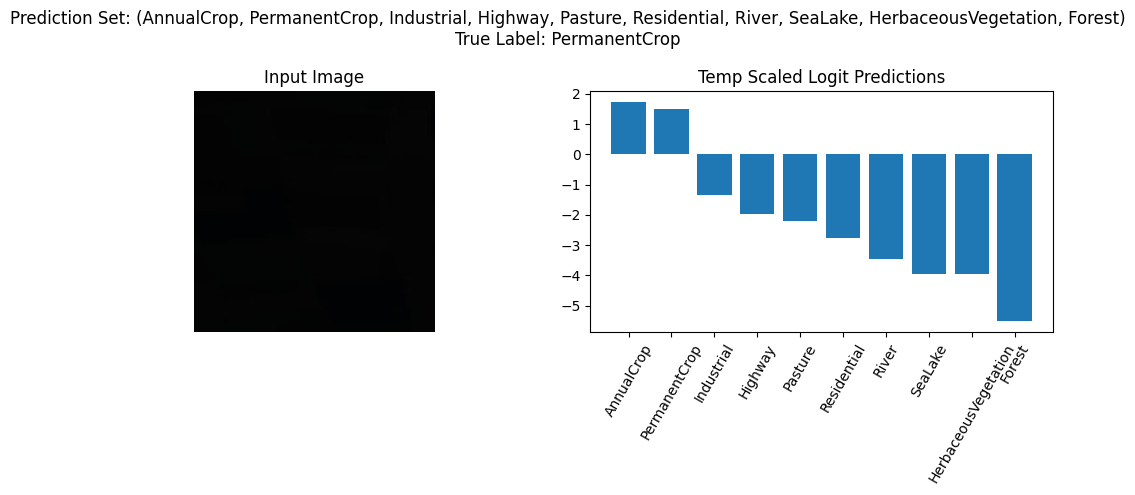

In [13]:
plot_random_sample(preds, predict_batch["image"], predict_batch["label"], class_labels)

In [72]:
# TODO demonstrate improved empirical coverage over baseline results
# do a bit of finetuning to see if we can improve the results